### venv location:
activate the following: `~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

In [1]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model.pt'


In [2]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

In [3]:
MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/old/model.pt'
PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

if not PRECALCULATED:
    model = torch.load(MODEL_PATH, weights_only=False)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        method='meanshift'
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        
        if embeddings.shape[0] == 0:
            this_predicted_binding_sites.append((cluster_residue_indices, 'finetuned model with smoothing'))
            this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))

            continue

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)

        # TODO: This is weird, fix later
        if indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD].shape[0] == 0:
            this_predicted_binding_sites.append((cluster_residue_indices, 'finetuned model with smoothing'))
            this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
            continue
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites_tmp = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0])]
    assert len(this_predicted_binding_sites_tmp) == len(this_predicted_binding_sites), f"Sorting error, {len(this_predicted_binding_sites)} != {len(this_predicted_binding_sites_tmp)}."
    predicted_binding_sites[protein_id] = this_predicted_binding_sites_tmp

if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

    import pickle

    for protein_id in sequences.keys():
        filename = protein_id.replace('_','')
        with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
            pickle.dump(predicted_binding_sites[protein_id], f)


0.5777390293519326 (0.22842197035745423)


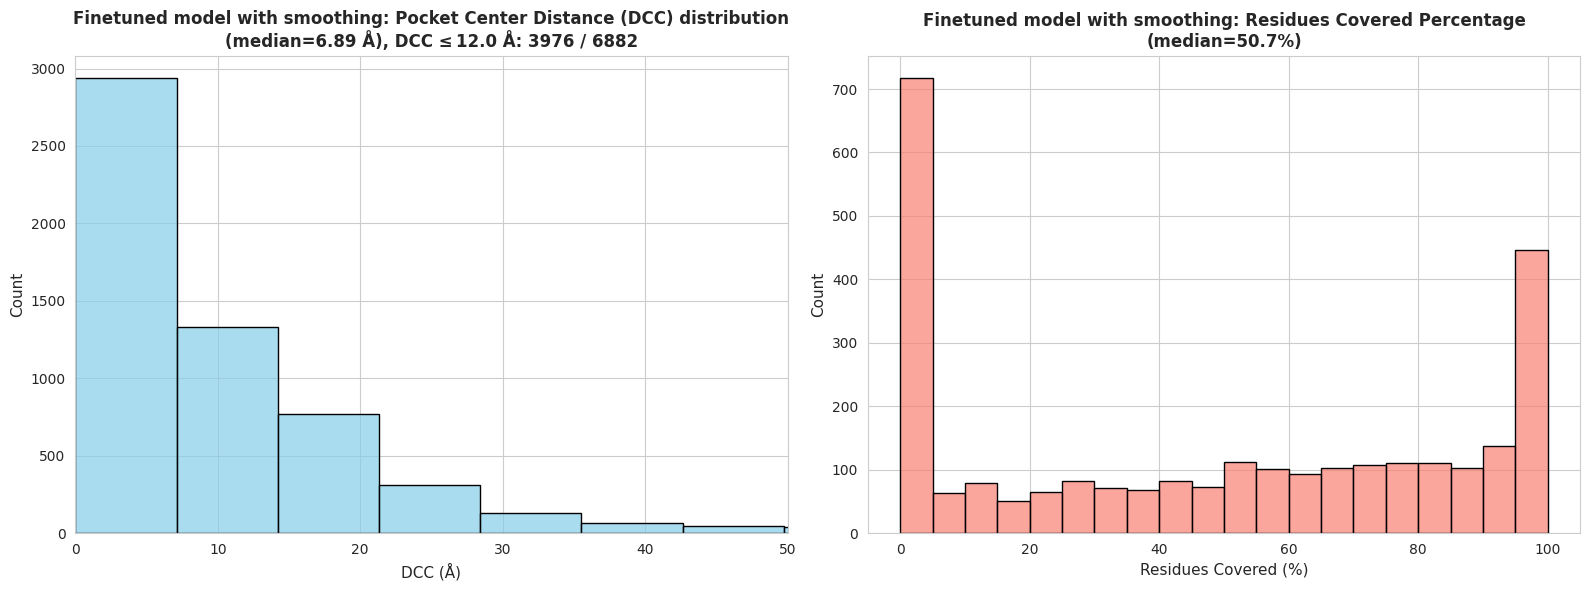

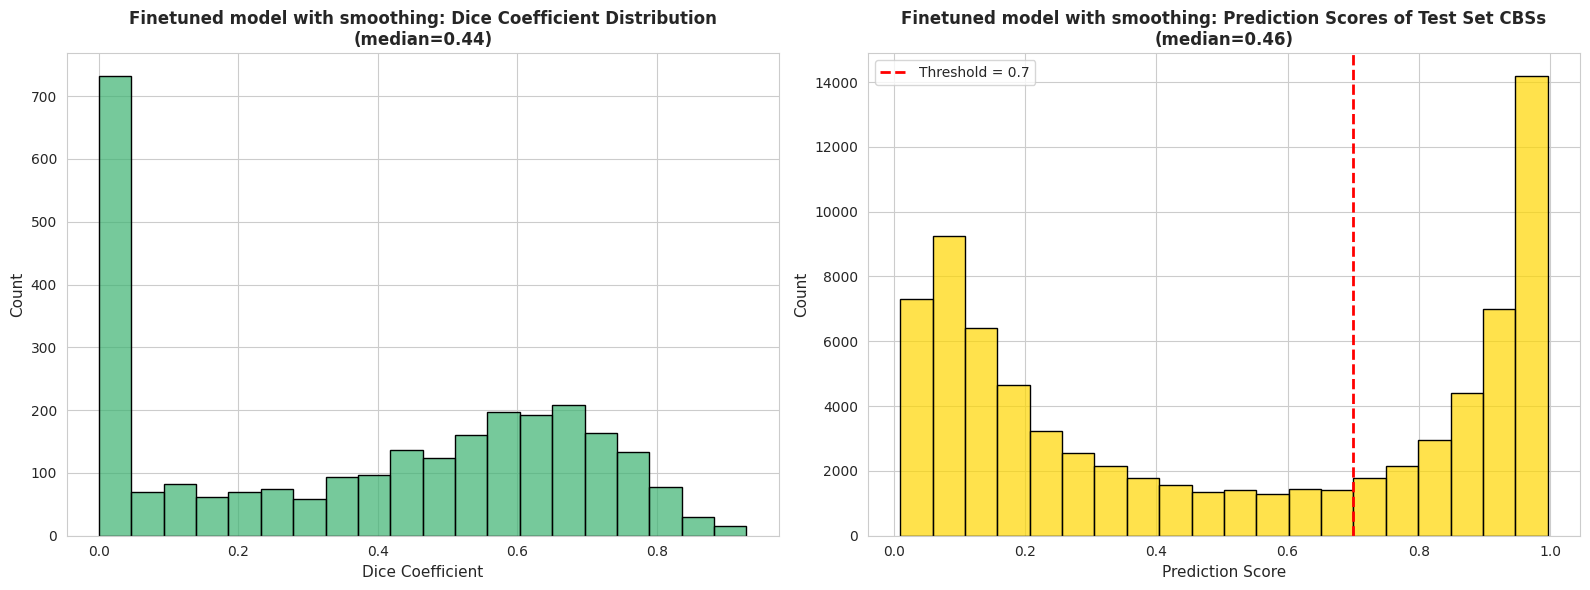

In [5]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)

In [ ]:
# DBSCAN smoothing results:
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.31923859343214184 (0.055943039814007556)
# N+2: 0.34510316768381283 (0.07919209532112757)
# MAX: 0.45669863411798894 (0.15925603022377216)

# MeanShift smoothing results:
# Eval method | DCC < 12 | DCC < 4

In [6]:
print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')


Eval method | DCC < 12 | DCC < 4
N+0: 0.44216797442603895 (0.05768671897704156)
N+2: 0.525573961057832 (0.0912525428654461)


In [7]:
import sys
from sklearn.cluster import DBSCAN

no_smoothing_predicted_binding_sites = {}
no_smoothing_prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    
    if not PRECALCULATED or protein_id not in prediction_scores:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
        sequence,
        embeddings_path
        )
    elif protein_id in prediction_scores:
        # load precalculated prediction
        prediction = prediction_scores[protein_id]
    elif PRECALCULATED:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')

    predicted_indices = np.where(prediction > DECISION_THRESHOLD)[0]

    # compute clusters without smoothing
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    coordinates = np.load(coordinates_path)

    high_score_points = coordinates[predicted_indices]  # Extract only (x, y, z) coordinates

    EPS = 5  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        no_smoothing_predicted_binding_sites[protein_id] = []
        no_smoothing_predicted_binding_sites[protein_id].append((predicted_indices, 'finetuned model without smoothing'))
        no_smoothing_prediction_scores[protein_id] = prediction
        continue
    
    from sklearn.cluster import MeanShift
    meanshift = MeanShift(bandwidth=EPS)
    labels = meanshift.fit_predict(high_score_points)

    # Initialize all labels to -1
    clusters = -1 * np.ones(len(prediction), dtype=int)
    # Assign cluster labels to high score points
    clusters[predicted_indices] = labels
    clusters_indices = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_indices = np.where(clusters == cluster_label)[0]
        clusters_indices.append(cluster_indices)

    no_smoothing_prediction_scores[protein_id] = prediction
    no_smoothing_predicted_binding_sites[protein_id] = [(i, 'finetuned model without smoothing') for i in clusters_indices]

0.12380122057541412 0.6255448997384482 6882


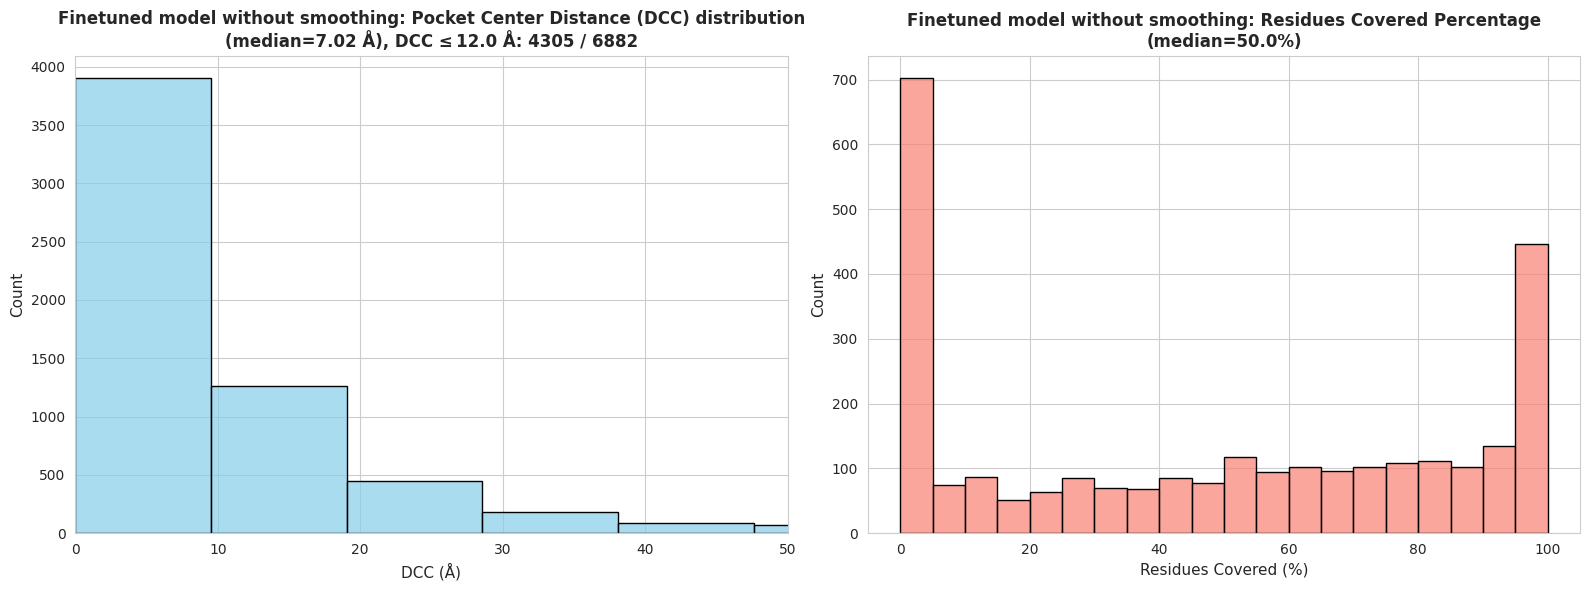

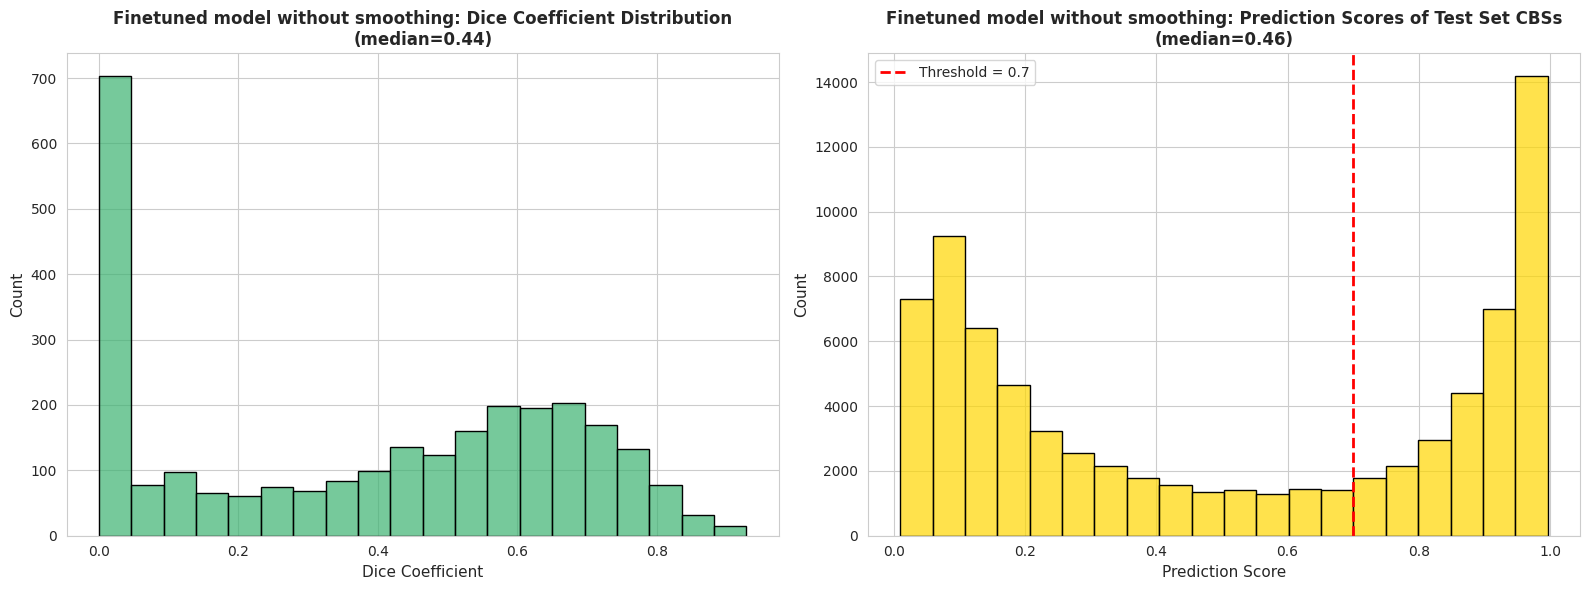

In [8]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model without smoothing'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, no_smoothing_predicted_binding_sites, no_smoothing_prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets, number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)

# min sapmples = 1, eps=1.7: 0.15528327065388814 0.4827126046342351 8243
# min sapmples = 1, eps=1.7: 0.15528327065388814 0.4827126046342351 8243

# scPDB-enhanced model

In [ ]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
ranks = {}

#####
def compute_clusters(
    points: list[list[float]],
    prediction_scores: list[float],
    decision_threshold: float = DECISION_THRESHOLD,
    eps=5,
    min_samples=3
):
    from sklearn.cluster import DBSCAN, MeanShift
    """
    Compute clusters based on the given points and prediction scores.

    Args:
        points (list[list[float]]): A list of points, where each point is a list of 3 coordinates [x, y, z].
        prediction_scores (list[float]): A list of prediction scores corresponding to each point.
        decision_threshold (float): The threshold above which points are considered as positive.

    Returns:
        np.ndarray: An array of cluster labels for each point. Points with no cluster are labeled as -1.
    """
    
    prediction_scores = prediction_scores.reshape(-1, 1)
    stacked = np.hstack((points, prediction_scores))  # Combine coordinates with scores

    high_score_mask = stacked[:, 3] > decision_threshold
    high_score_points = stacked[high_score_mask][:, :3]  # Extract only (x, y, z) coordinates

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < min_samples:
        return -1 * np.ones(len(points), dtype=int)

    dbscan = MeanShift(bandwidth=eps)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    all_labels = -1 * np.ones(len(points), dtype=int)
    # Assign cluster labels to high score points
    all_labels[high_score_mask] = labels
    labels = all_labels

    return labels
######


prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)

    clusters = compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        eps=5,
        min_samples=3
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0])]
    predicted_binding_sites[protein_id] = this_predicted_binding_sites

if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

0.8100842778262133 0.4043882592269689


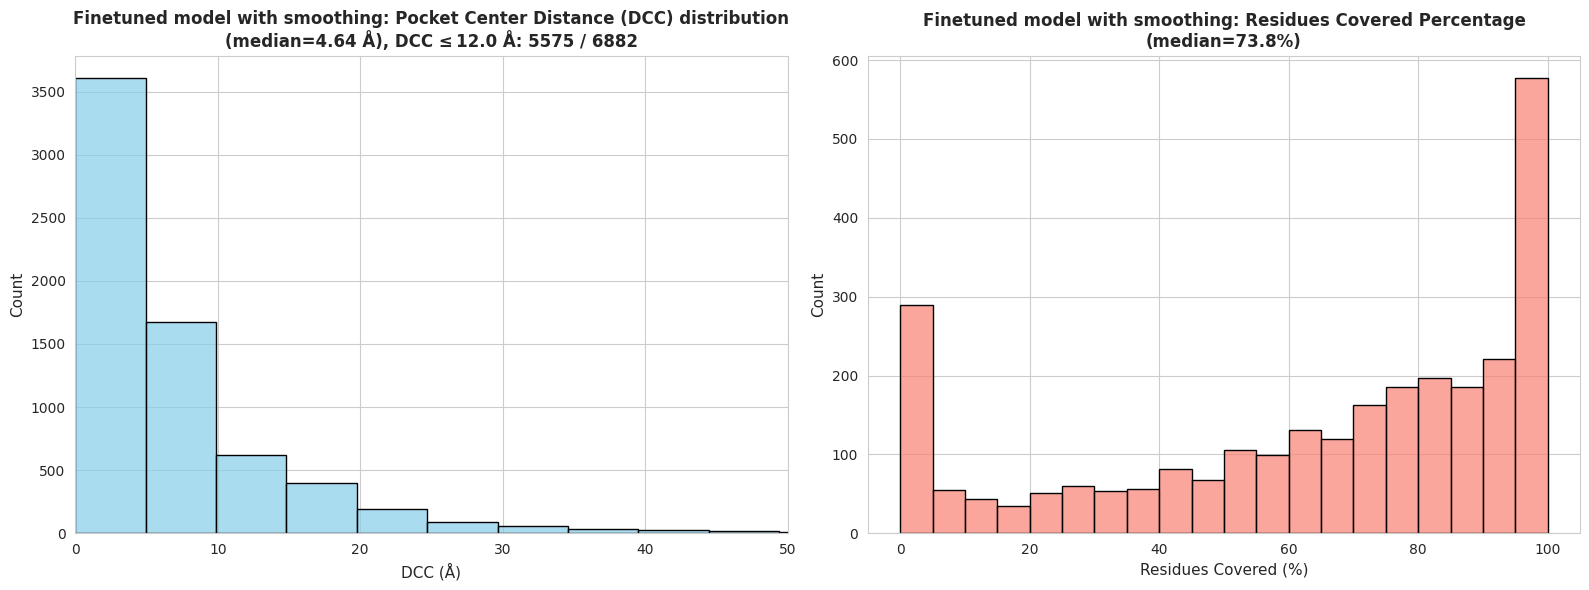

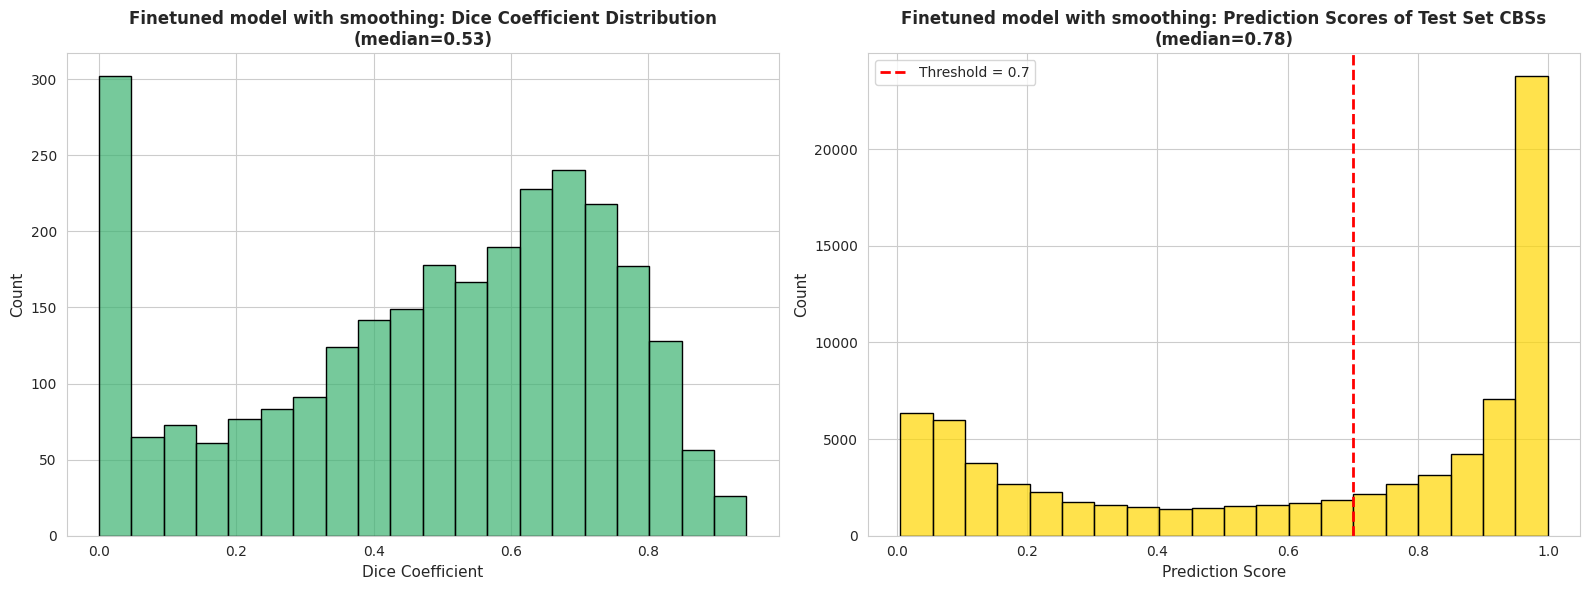

In [ ]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, np.sum(np.array(DCCs) < 4) / number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)
# 0.8: 0.16216216216216217 0.4398430688753269
# 0.5: 0.22246439988375472 0.6287416448706771


## TOP-N, TOP-N+K

In [ ]:
# DBSCAN
# EPS=4, MIN_SAMPLES=2:
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.547660563789596 (0.1020052310374891)
# N+2: 0.6384771868642837 (0.15911072362685266)
# MAX: 0.7176692821854113 (0.2946817785527463)

# EPS=5, MIN_SAMPLES=3:
# N+0: 0.46657948270851496 (0.09096192967160709)
# N+2: 0.5161290322580645 (0.12002324905550713)
# MAX: 0.6303400174367916 (0.22551583841906422)


### MeanShift
# EPS=5
#

In [ ]:
print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')


Eval method | DCC < 12 | DCC < 4
N+0: 0.5350188898575995 (0.08544027898866609)
N+2: 0.6749491426910782 (0.14080209241499564)


## no smoothing
measure how performance changes when no smoothing is applied, only clustering.

In [ ]:
import sys
from sklearn.cluster import DBSCAN

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'

no_smoothing_predicted_binding_sites = {}
no_smoothing_prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    
    if not PRECALCULATED or protein_id not in prediction_scores:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
        sequence,
        embeddings_path
        )
    elif protein_id in prediction_scores:
        # load precalculated prediction
        prediction = prediction_scores[protein_id]
    elif PRECALCULATED:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')

    predicted_indices = np.where(prediction > DECISION_THRESHOLD)[0]

    # compute clusters without smoothing
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    coordinates = np.load(coordinates_path)

    high_score_points = coordinates[predicted_indices]  # Extract only (x, y, z) coordinates

    EPS = 5  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        no_smoothing_predicted_binding_sites[protein_id] = []
        no_smoothing_predicted_binding_sites[protein_id].append((predicted_indices, 'finetuned model without smoothing'))
        no_smoothing_prediction_scores[protein_id] = prediction
        continue
    
    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    clusters = -1 * np.ones(len(prediction), dtype=int)
    # Assign cluster labels to high score points
    clusters[predicted_indices] = labels
    clusters_indices = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_indices = np.where(clusters == cluster_label)[0]
        clusters_indices.append(cluster_indices)

    no_smoothing_prediction_scores[protein_id] = prediction
    no_smoothing_predicted_binding_sites[protein_id] = [(i, 'finetuned model without smoothing') for i in clusters_indices]

0.15794827085149665 0.6349898285382156 6882


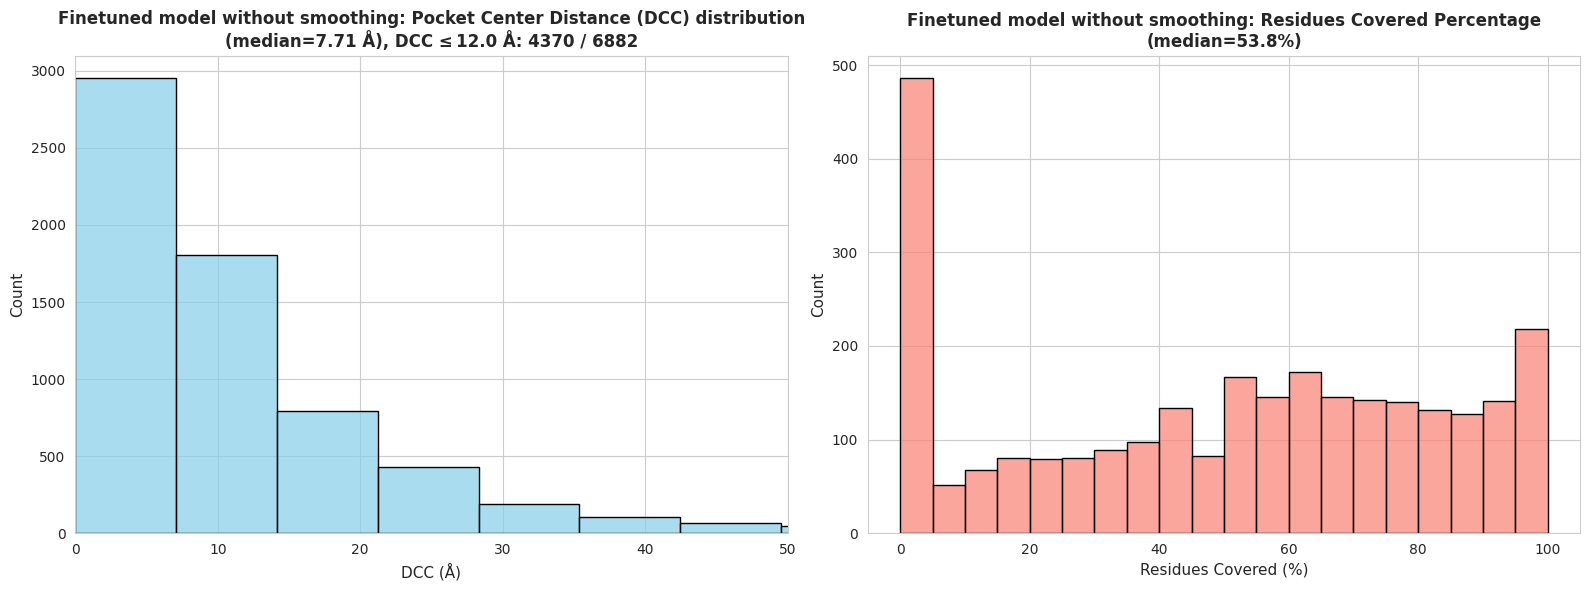

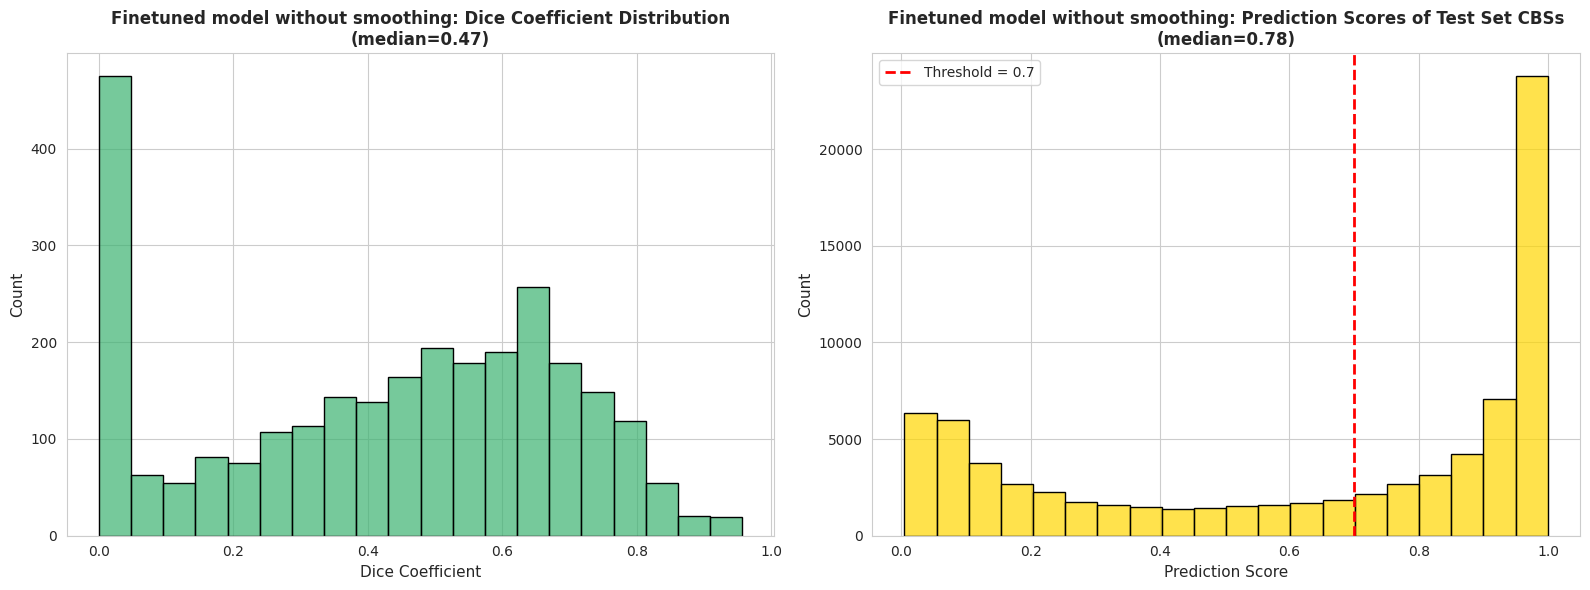

In [ ]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model without smoothing'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, no_smoothing_predicted_binding_sites, no_smoothing_prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets, number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)


## load & merge predictions
Because there is this mess with PDB numbering vs. auth numbering, we need to translate the chain ids from PDB to auth.

In [ ]:
import pickle

with open('/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/LIGYSIS_sites_DEF_TRANS.pkl', 'rb') as file:
    df = pickle.load(file)

auth_to_label_chain_mapping = {}
for pdb_id, auth_chain_id, label_chain_id in zip(df['pdb_id'], df['auth_asym_id'], df['struct_asym_id']):
    auth_to_label_chain_mapping[(pdb_id, auth_chain_id)] = label_chain_id

# load p2rank predictions and format the pockets in the same way as our model's predictions
with open('/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB/p2rank_predictions_reformated.pkl', 'rb') as f:
    p2rank_predicted_pockets = pickle.load(f)
    p2rank_predicted_pockets = {protein_id: [(np.array([int(residue[1:]) for residue in pocket]), method) for (pocket, method) in pockets] for protein_id, pockets in p2rank_predicted_pockets[0].items()}

# map p2rank chain ids from auth to label
# p2rank_predicted_pockets = {f'{protein_id[:4]}{auth_to_label_chain_mapping[(protein_id[:4], protein_id[4:])]}': pockets for protein_id, pockets in p2rank_predicted_pockets.items() }

#predicted_binding_sites
merged_predictions = {}
p2rank_predicted_structures_count = 0
for protein_id in sequences.keys():
    protein_id_without_dash = protein_id.replace('_', '')
    merged_predictions[protein_id] = []
    # add finetuned model predictions
    for binding_sites in predicted_binding_sites[protein_id_without_dash]:
        merged_predictions[protein_id].append(binding_sites)
    # add p2rank predictions
    if protein_id_without_dash in p2rank_predicted_pockets:
        p2rank_predicted_structures_count += 1
        for binding_sites in p2rank_predicted_pockets[protein_id_without_dash]:
            merged_predictions[protein_id].append(binding_sites)

assert p2rank_predicted_structures_count == 2579, f"Number of structures with p2rank predictions is {p2rank_predicted_structures_count}, but should be 2579. (see src/E-regular-binding-site-predictor/evaluation/pocket-level-evaluation-p2rank.ipynb for details)"

0.35222319093286836 0.7580645161290323


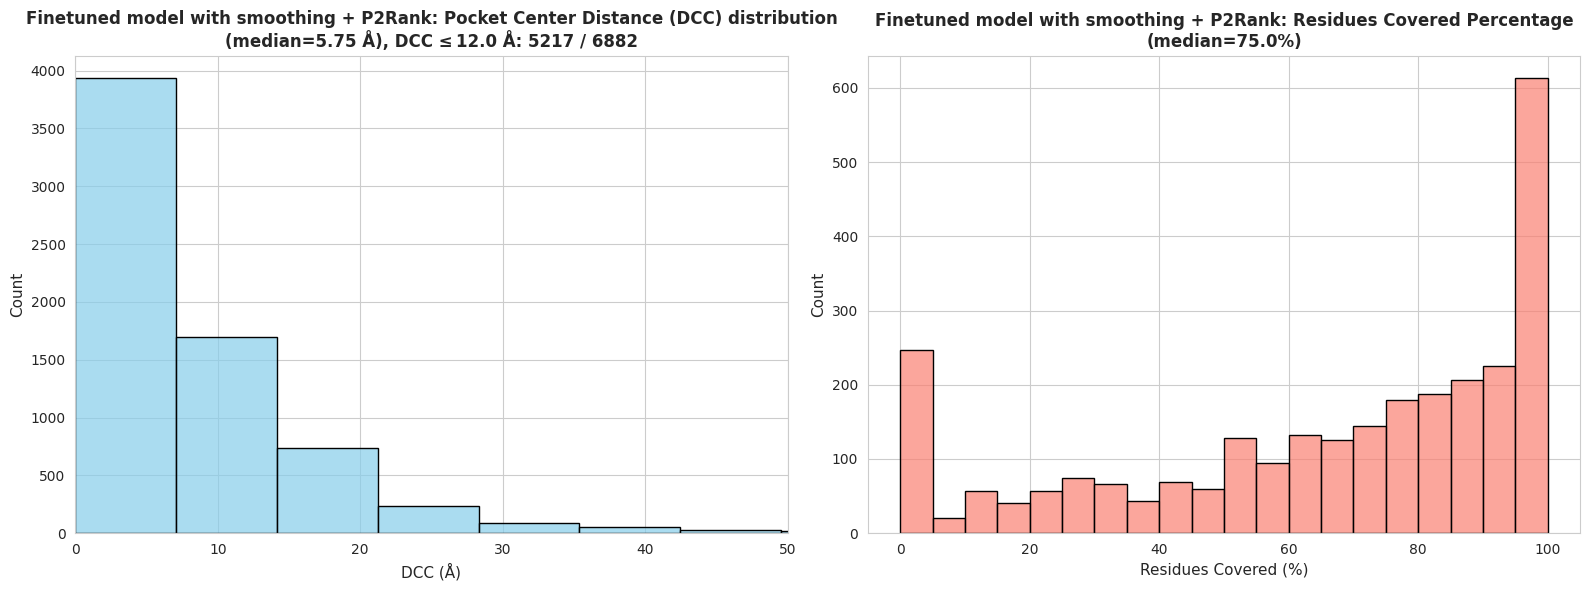

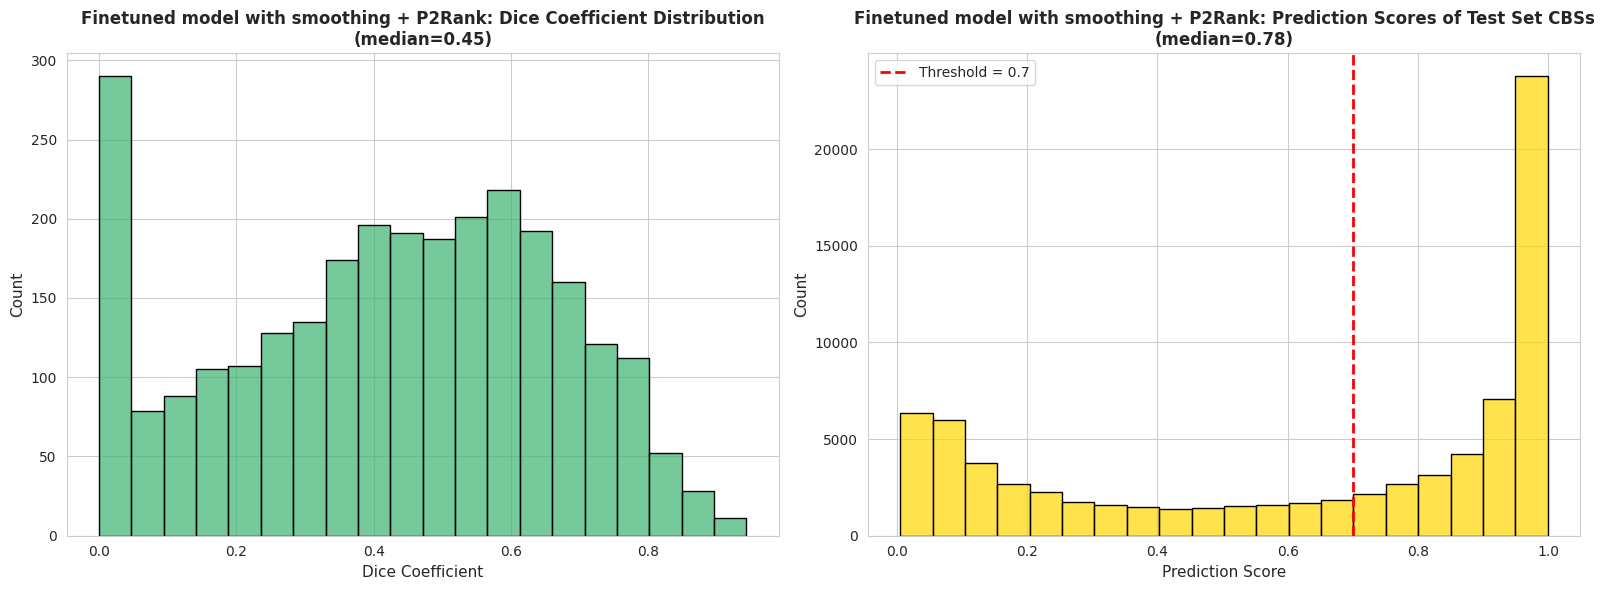

In [ ]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing + P2Rank'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, merged_predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)
# 0.8: 0.16216216216216217 0.4398430688753269
# 0.5: 0.22246439988375472 0.6287416448706771
# P2rank + finetuning with smoothing: 0.35222319093286836 0.7580645161290323
# P2rank + finetuning without smoothing: 0.3188026736413833 0.7621331008427783

## Residue-level metrics for merged predictions


In [ ]:
from sklearn import metrics

actual_labels = []
predicted_labels = []

for protein_id in sequences.keys():
    actual_labels_indices = [np.array([int(residue.split('_')[1]) for residue in pocket]) for pocket in binding_residues[protein_id]]
    this_actual_labels = np.zeros(len(sequences[protein_id]))
    for pocket_indices in actual_labels_indices:
        this_actual_labels[pocket_indices] = 1

    this_predicted_labels = np.zeros(len(sequences[protein_id]))
    for pocket_indices, method in merged_predictions[protein_id]:
        this_predicted_labels[pocket_indices] = 1
    actual_labels.append(this_actual_labels)
    predicted_labels.append(this_predicted_labels)

actual_labels = np.concatenate(actual_labels)
predicted_labels = np.concatenate(predicted_labels)

mcc = metrics.matthews_corrcoef(actual_labels, predicted_labels)
f1 = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
binary_f1 = metrics.f1_score(actual_labels, predicted_labels)
precision, recall, thresholds2 = metrics.precision_recall_curve(actual_labels, predicted_labels)
auprc = metrics.auc(recall, precision)
print(f"MCC: {mcc:.4f}, F1: {f1:.4f}, binary F1: {binary_f1:.4f}; Predicted {sum(predicted_labels)} vs. Actual {sum(actual_labels)}")


MCC: 0.3869, F1: 0.8625, binary F1: 0.4375; Predicted 158784.0 vs. Actual 78205.0
